# *Tutorial: how to use Polarization-aware Pado🌊🌊*
This jupyter notebook provides an introduction to `polarization` elements in `Pado`. Through this notebook, you will learn the basic building blocks of polarization: light, optical element, and propagator.

---

In your project folder, put the folder of pado like below
- YOUR PROJECT FOLDER
  - pado
    - light.py
    - optical_element.py
    - propagator.py
    - ...

In [1]:
cd ../..

c:\Users\DARI\Desktop\PADO\pado-internal


In [2]:
pwd

'c:\\Users\\DARI\\Desktop\\PADO\\pado-internal'

## **🌊 Step 1: import Pado**
First, you should import Pado. Make sure to install all the dependency :) 

In [3]:
import torch
import numpy as np
import pado
import cv2
import matplotlib.pyplot as plt

## **💡Step 2: everything starts from light**

The fundamental element of `polarization-aware Pado` is `polarize light`. As we want to simulate how `polarized light` wave interacts with other optical elements and propagate in free space, we should start from defining polarized light. Based on wave optics, we represent polarized light wave as a 2D complex-valued field on a virtual plane for each component. That is, each complex-valued element in the array represents the phase and ampiltude of light wave at that spatial location. 

We should first define the resolution of the light we want to simulate as

In [4]:
R = 1080
C = 1920
dim = (1, 1, R, C)
pitch = 6.4e-6
wvl = 550e-9
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Then, we define the polarized light. This can be easily done using the class `PolarizedLight`. By default, it initializes the amplitude as one and the phase as zero, resulting in a planar wave. Note that we  store the data in GPU here, so we supply 'cuda:0' for the device argument. We can visualize the content of light with the `visualize()` function.

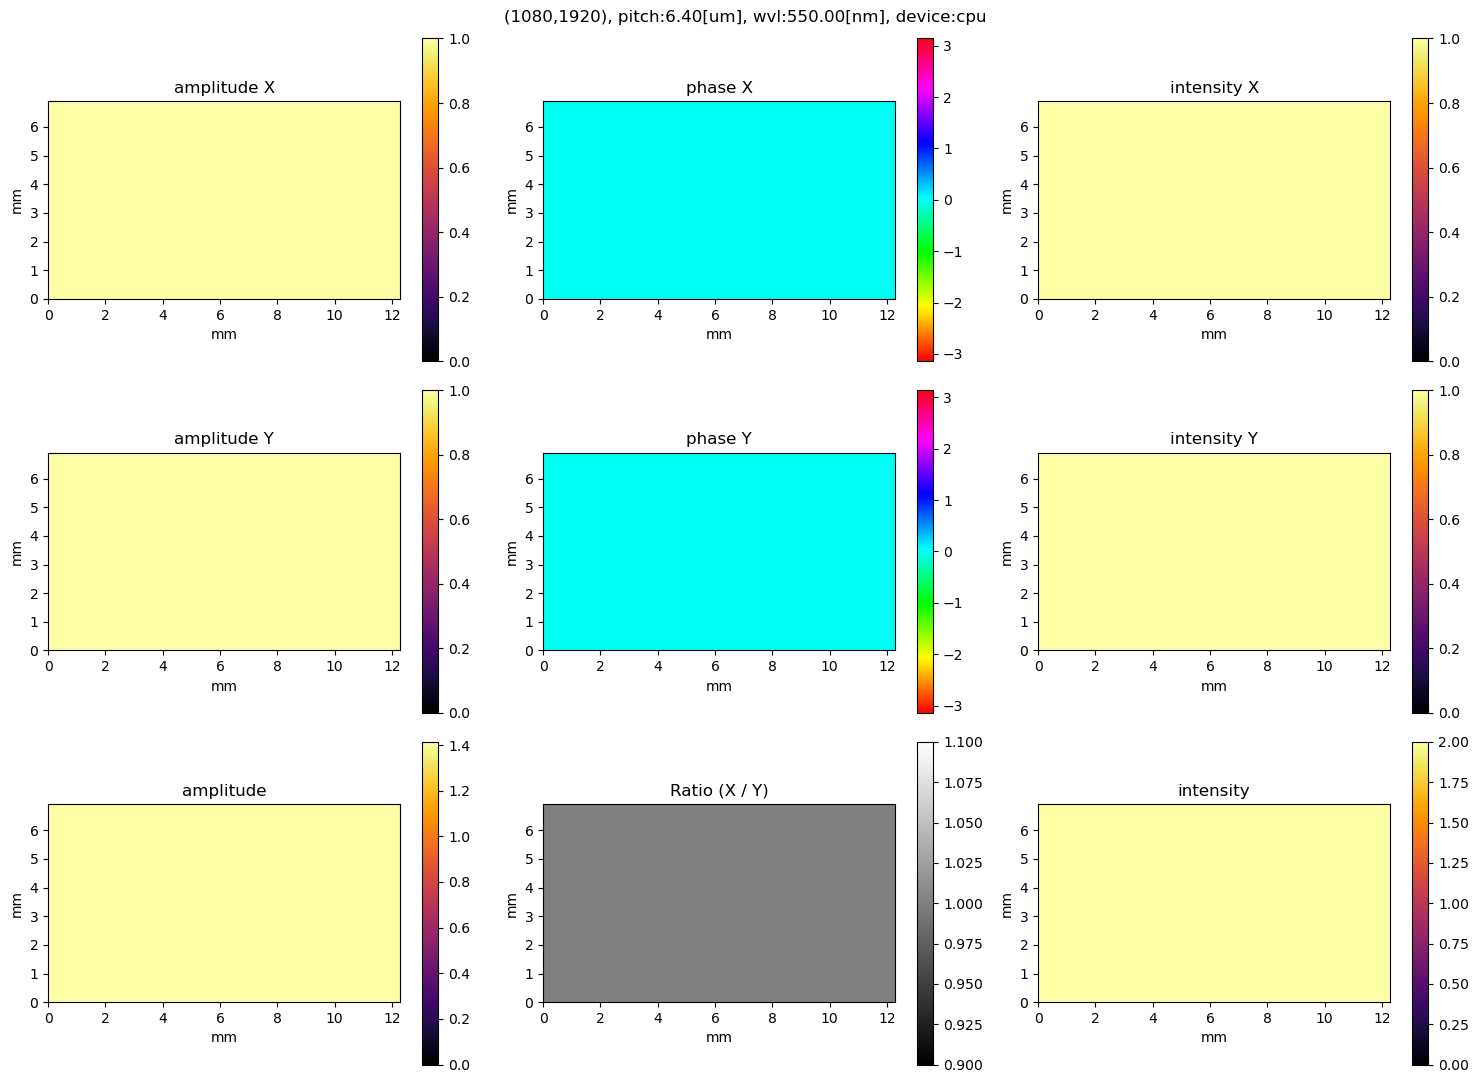

In [5]:
light = pado.light.PolarizedLight(dim,pitch=pitch,wvl=wvl,device=device)
light.visualize()

## **🔭Step 3: build your own imaging/display system**
In this tutorial, we will use a simple camera with a `refractive lens` and an `aperture`. Note that we provide various optical elements that can interact with and transform light wave. Let's first define the basic optical elements: lens and aperture. To apply polarization, set `polar='polar'`

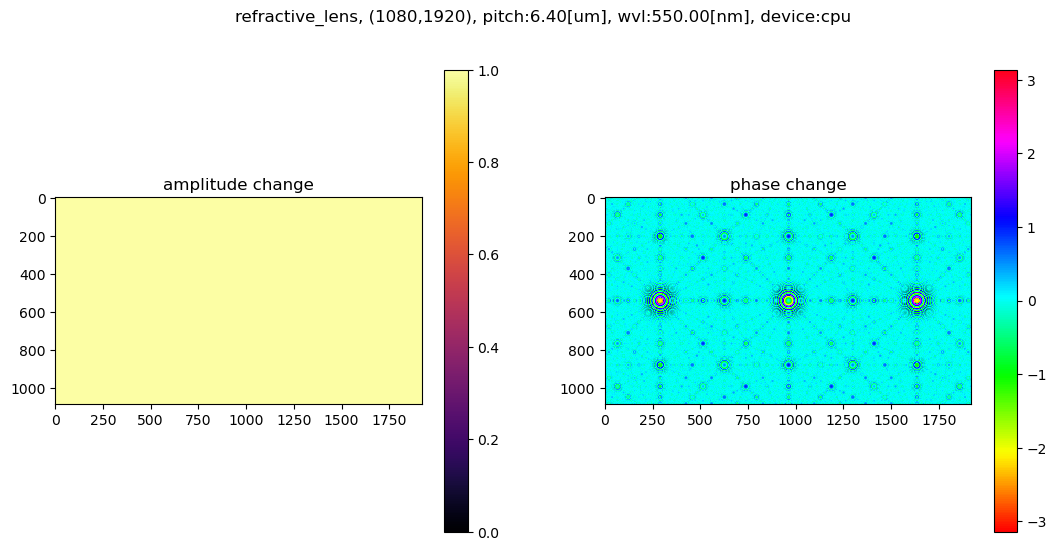

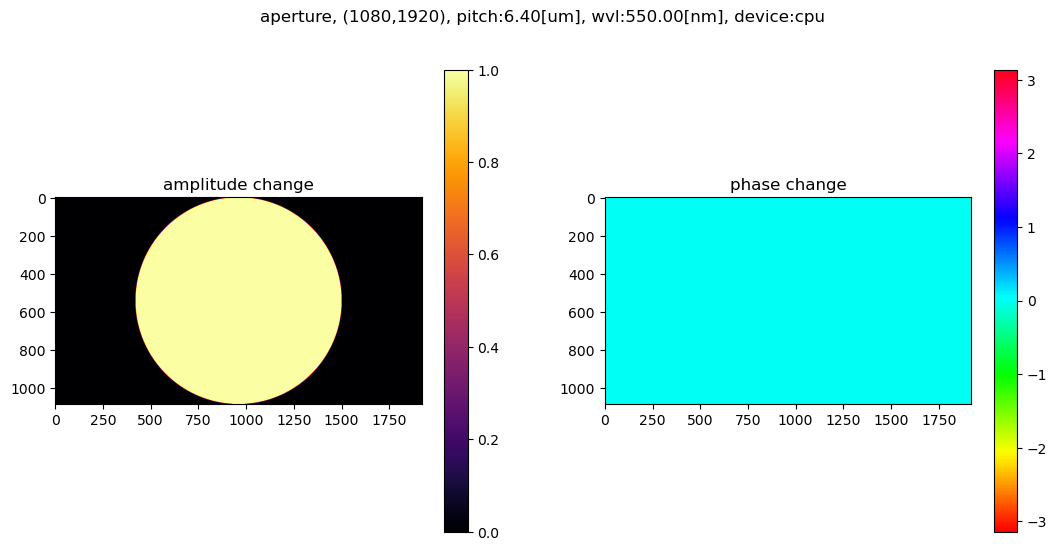

In [6]:
f = 50e-3  # focal length
lens = pado.optical_element.RefractiveLens(dim,pitch,f,wvl,device=device, polar='polar')
lens.visualize()

aperture = pado.optical_element.Aperture(dim, pitch, R*pitch, 'circle', wvl, device=device, polar='polar')
aperture.visualize()


Now, we want to simulate the point spread function (PSF) of this camera. In order to do this, we should use light, lens, aperture, and also propagator. The propagator computes how phase and amplitude of light changes after free-space propagation by a specific distance. Specifically, we use Fresnel propagator which is valid for short propagation distances. To apply polarization, set `polar='polar'`

In [7]:
prop = pado.propagator.Propagator('Fresnel', polar='polar')

Let's combine everything together and simulate the system's PSF now. Key here is the function `forward` that takes the light and outputs the light after interaction with either the optical element or the propagator.

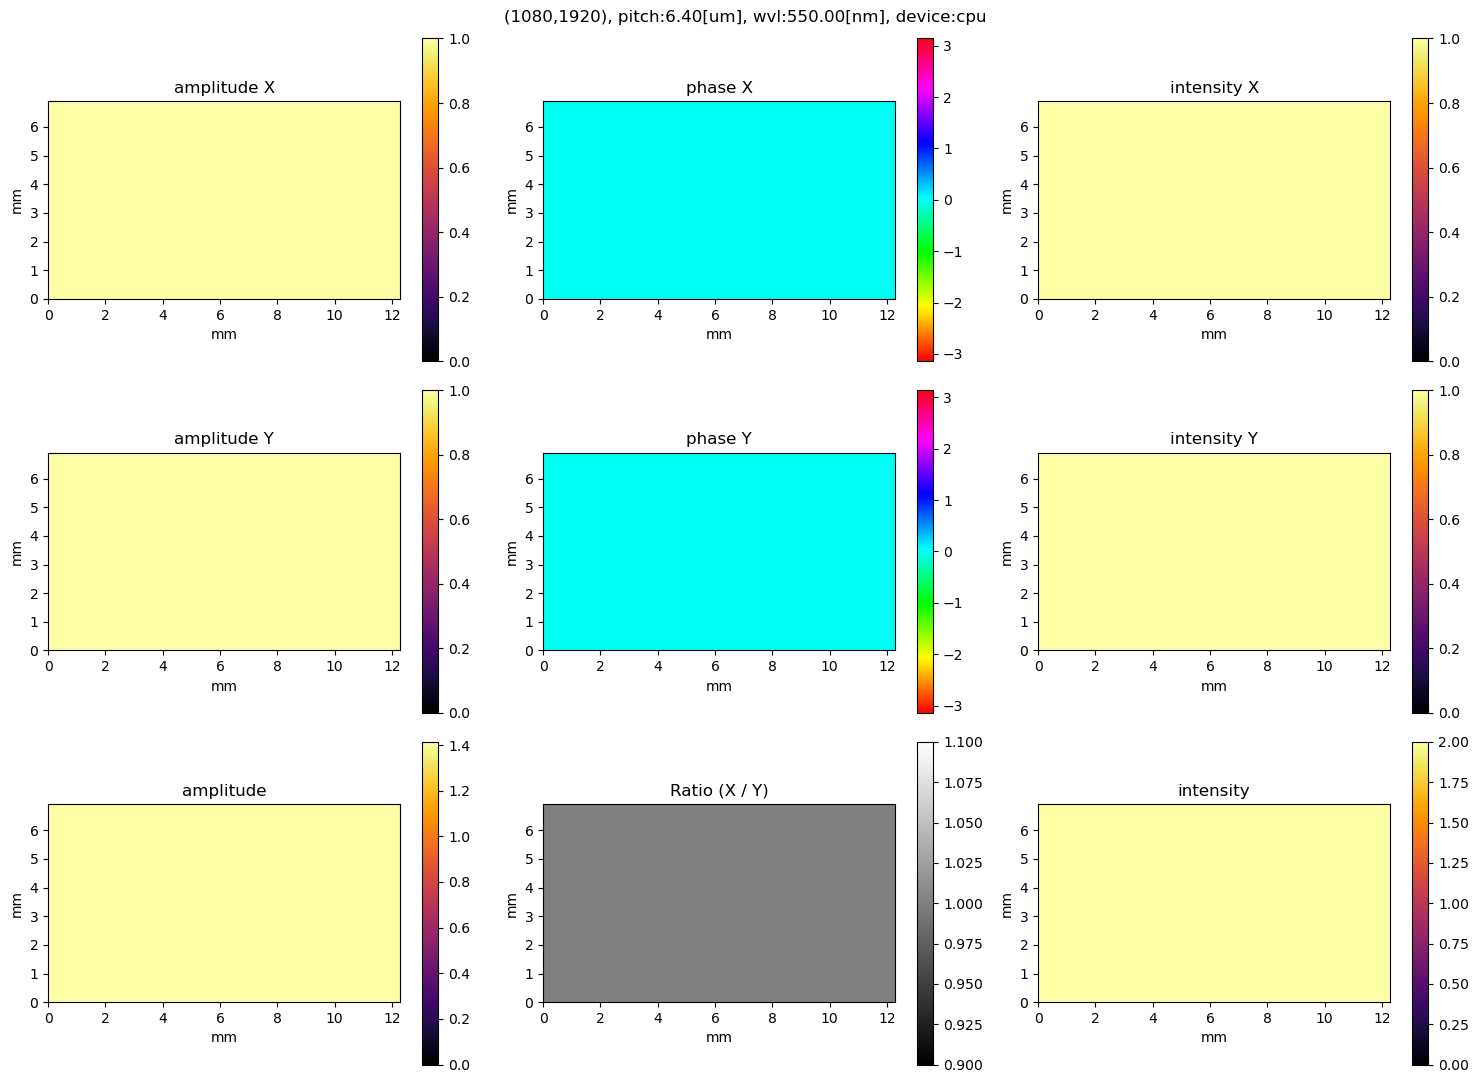

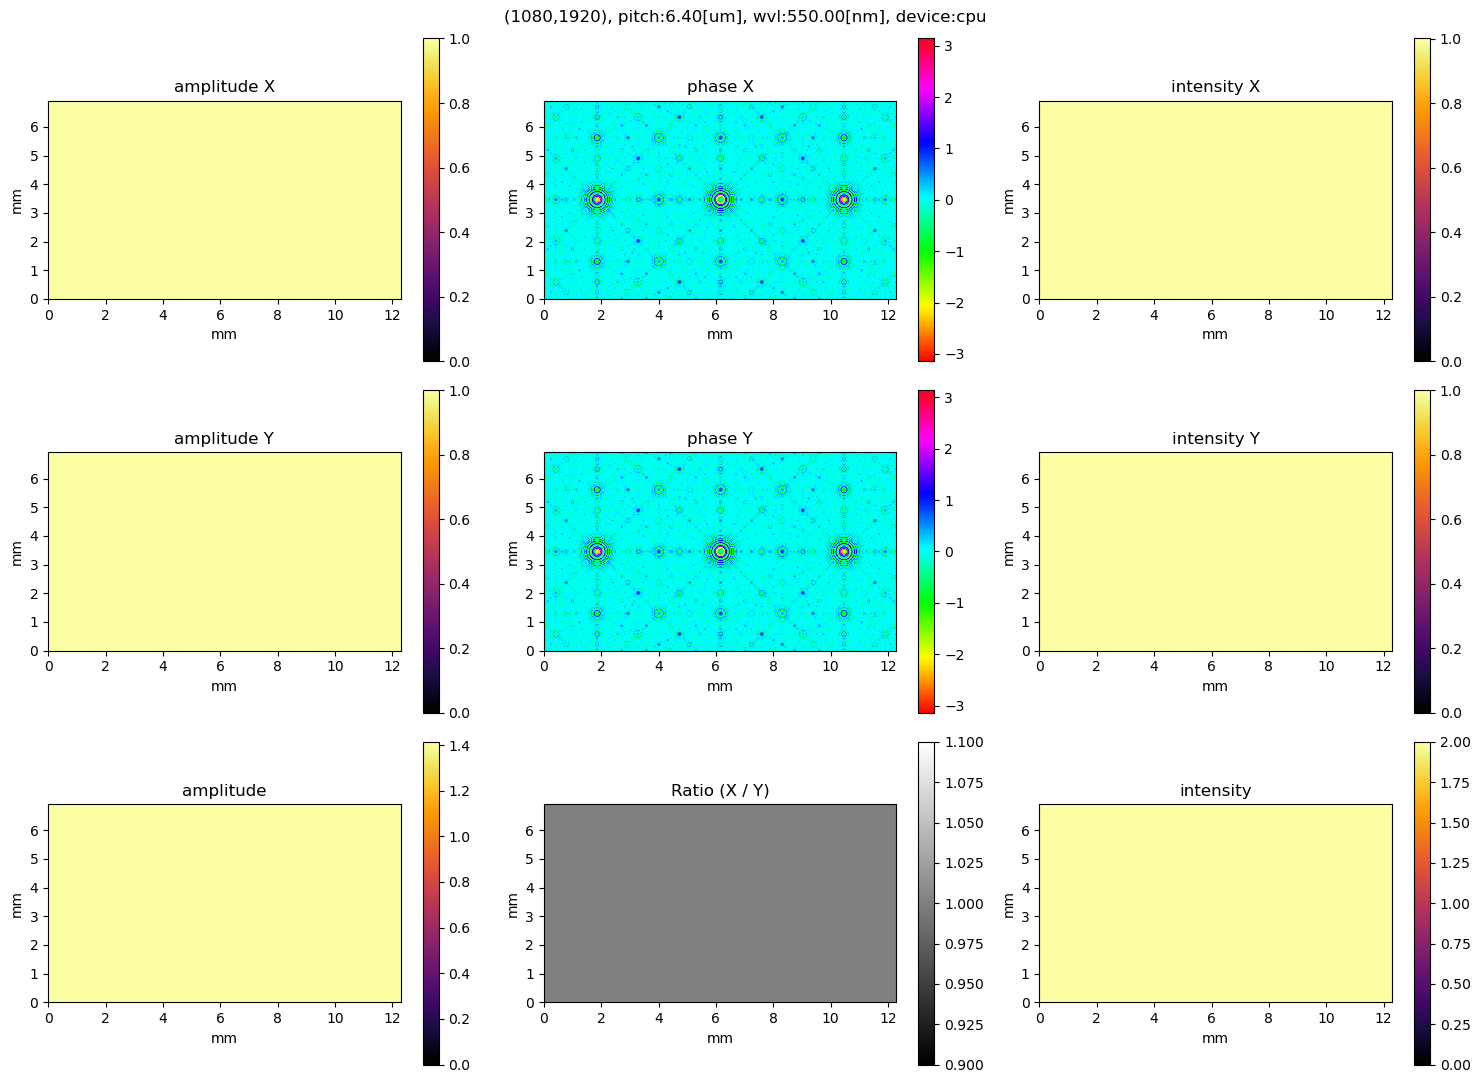

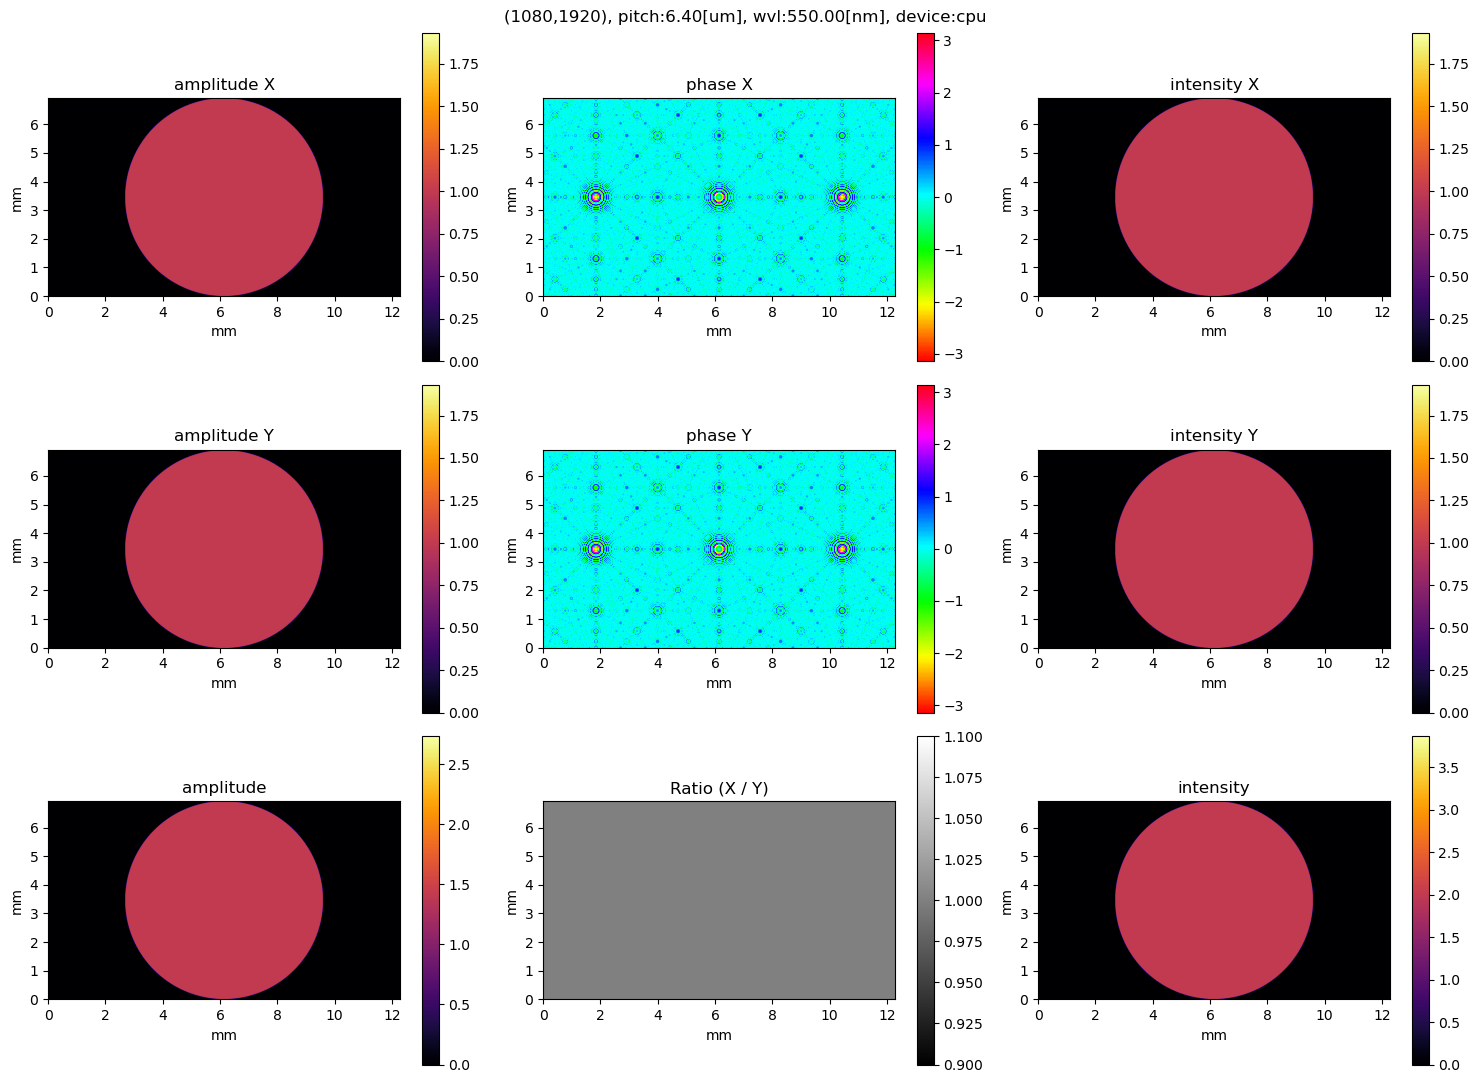

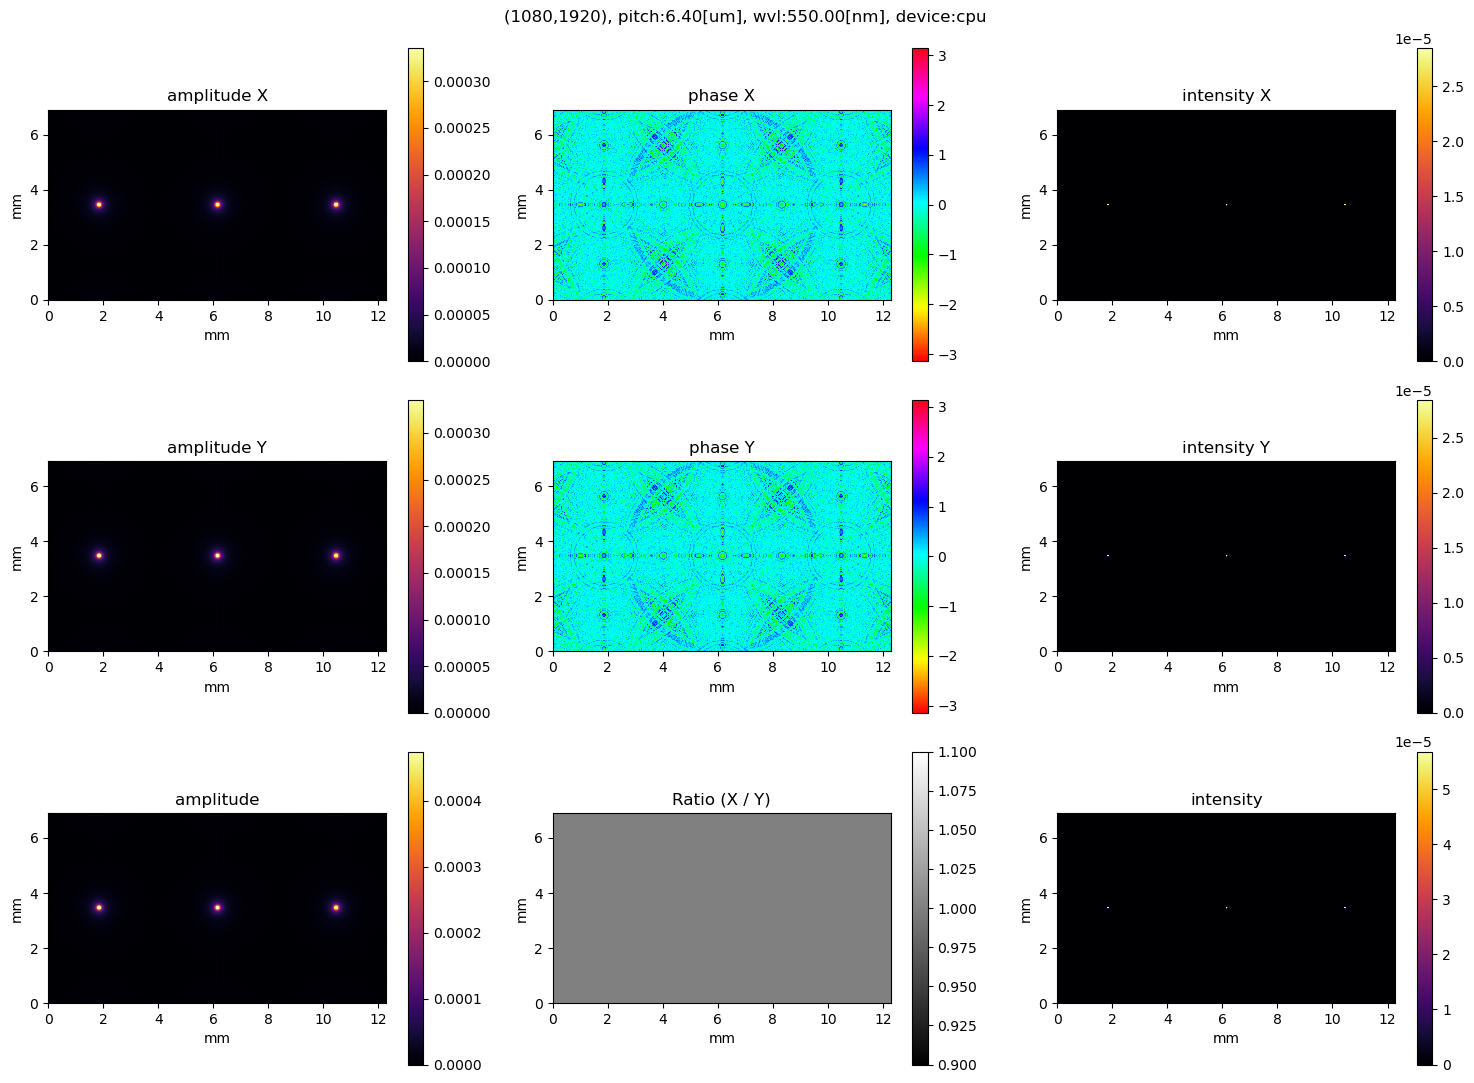

In [8]:
light.visualize()

light_after_lens = lens.forward(light)
light_after_lens.visualize()

light_after_aperture = aperture.forward(light_after_lens)
light_after_aperture.visualize()

light_after_prop = prop.forward(light_after_aperture, f)
light_after_prop.visualize()

## 🔄 Step 4: use polarization-aware SLM
In this tutorial, we will use a SLM which can modulate phase of each polarization component of light. `PolarizedSLM` can modulate each component respectively. Let's first define the polarization-aware SLM.

In [9]:
light = pado.light.PolarizedLight(dim,pitch=pitch,wvl=wvl,device=device)
f = 50e-3  # focal length
lens = pado.optical_element.RefractiveLens(dim,pitch,f,wvl,device=device, polar='polar')
prop = pado.propagator.Propagator('ASM', polar='polar')

slm = pado.PolarizedSLM((dim[0], dim[1], dim[2], dim[3], 2), pitch, wvl, device)

We can define phase & amplitude modulation for each component. After loading phase of each component, we can set them as its phase modulation.

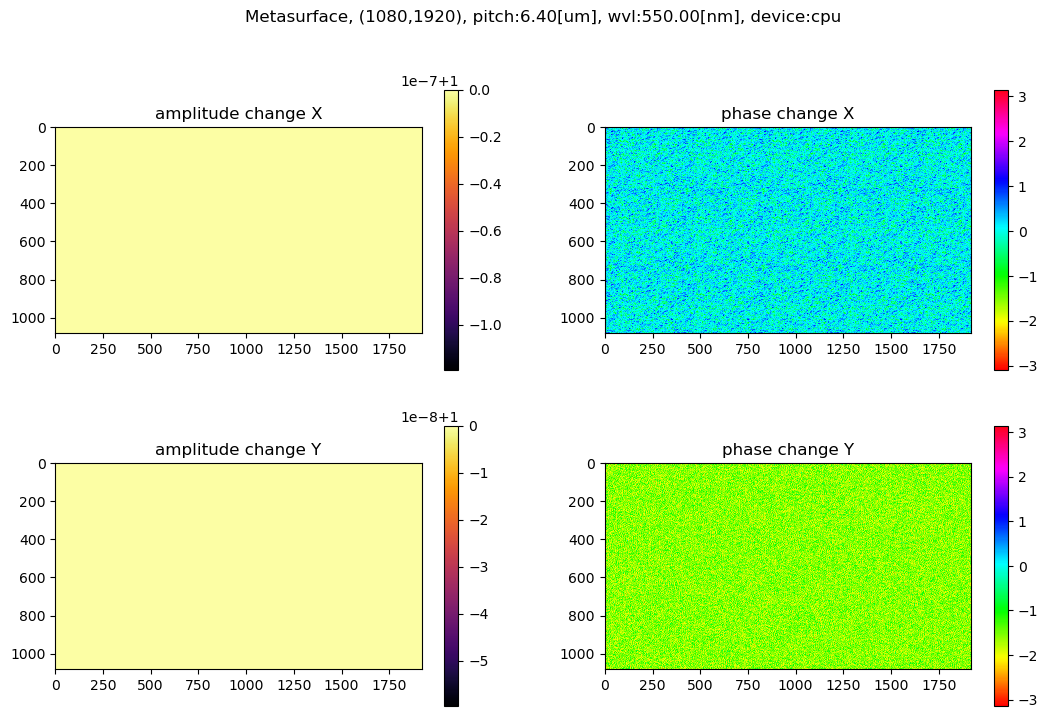

In [10]:
phaseX = torch.Tensor((cv2.imread('./example/asset/eins.png', 0))/255 * np.pi * 2 - np.pi).unsqueeze(0).unsqueeze(0).to(device)
phaseY = torch.Tensor((cv2.imread('./example/asset/jarvis.png', 0))/255 * np.pi * 2 - np.pi).unsqueeze(0).unsqueeze(0).to(device)

slm.set_phaseX_change(phaseX, wvl)
slm.set_phaseY_change(phaseY, wvl)

slm.visualize()

Propagating light through the SLM and the lens results in desired images for each component.

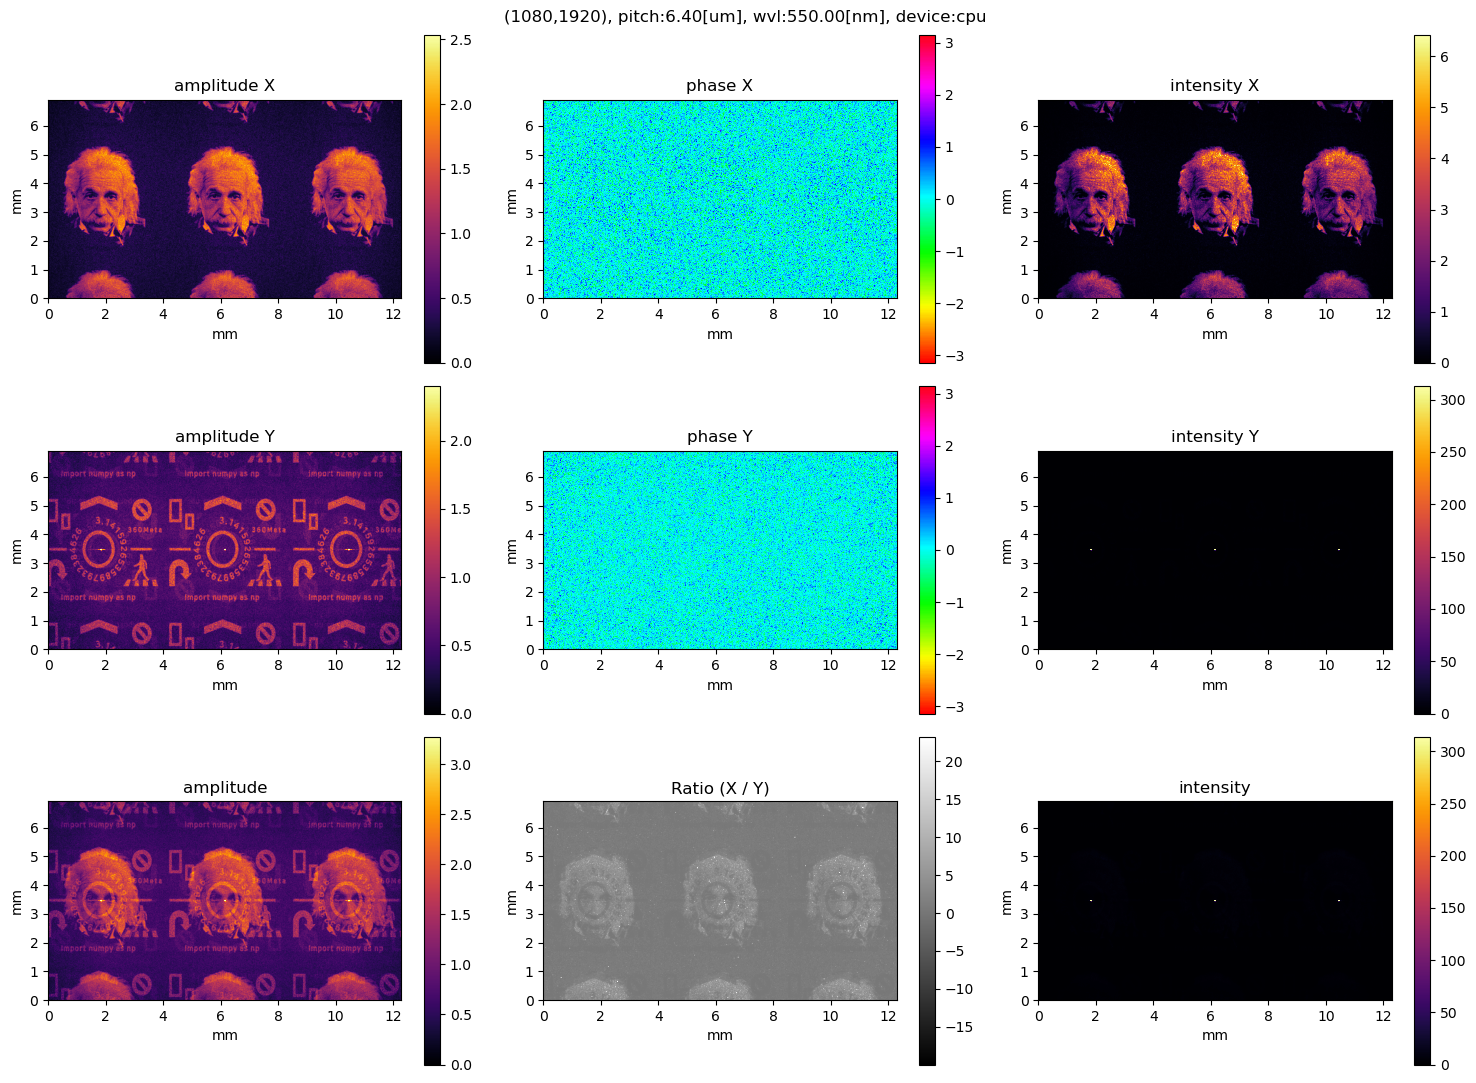

In [11]:
light_after_slm = slm.forward(light.clone())
light_after_lens = lens.forward(light_after_slm)
light_after_prop = prop.forward(light_after_lens, f)

light_after_prop.visualize()